In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/opt/extradata/competitive-data-science-predict-future-sales/"))

items_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/items.csv')
shops_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/shops.csv')

icats_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/item_categories.csv')
train_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/sales_train.csv', header=0, sep=',', quotechar='"')
smpsb_df = pd.read_csv('/opt/extradata/competitive-data-science-predict-future-sales/sample_submission.csv', header=0, sep=',', quotechar='"')
test_df  = pd.read_csv(r'/opt/extradata/competitive-data-science-predict-future-sales/test.csv', header=0, sep=',', quotechar='"')
# Any results you write to the current directory are saved as output.'''

['item_categories.csv', 'items.csv', 'shops.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'X_train_all.csv', 'y_train_all.csv', 'X_train.csv']


1.1 Sale Transactions¶
First, I have noticed that field 'item_price' in 'sales_train.csv' is likely to be the total revenue rather than the individual item price. For example, the item '20949' might have the individual item price as 5 rubles (or whatever unit)

In [2]:
train_df[train_df['item_id']==20949][:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,30.04.2013,3,22,20949,5.000000,12.0
352399,29.04.2013,3,22,20949,4.923077,13.0
352400,28.04.2013,3,22,20949,5.000000,4.0
352401,27.04.2013,3,22,20949,5.000000,4.0
352455,24.04.2013,3,22,20949,5.000000,2.0


In [3]:
# Chek train and test sets
print("# of rows in train_df = {0}".format(train_df.shape[0]))
print("unique date_block_num in train_df = {0}".format(train_df['date_block_num'].nunique()))
print("the value of date_block_num in train_df is between {0} - {1}".format(min(train_df['date_block_num']), max(train_df['date_block_num'])))
print()
print("3 first dates in date_block_num 0")
print(train_df.loc[train_df['date_block_num']==0, 'date'][:3])
print()
print("3 first dates in date_block_num 33")
print(train_df.loc[train_df['date_block_num']==33, 'date'][:3])

print()
print("# of rows in test_df = {0}".format(test_df.shape[0]))
print()
print("3 first rows in test_df")
test_df.head(3)

# of rows in train_df = 2935849
unique date_block_num in train_df = 34
the value of date_block_num in train_df is between 0 - 33

3 first dates in date_block_num 0
0    02.01.2013
1    03.01.2013
2    05.01.2013
Name: date, dtype: object

3 first dates in date_block_num 33
2882335    23.10.2015
2882336    05.10.2015
2882337    02.10.2015
Name: date, dtype: object

# of rows in test_df = 214200

3 first rows in test_df


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


So, the training data consist of sale transactions in 34 months, from January 2013 to October 2015. The test data have no date or block attributes, but we are informed that total sales of each shop and item in November 2015 must be predicted.

The main features that will be used in learning are lagged variables which are the sales of previous months. So, it is important to visualize the sale records of each month in the data.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
date_df = train_df['date'].str.split('.', expand=True)
train_df['month'] = date_df.loc[:, 1]
train_df['year'] = date_df.loc[:, 2]
train_df['year_month'] = train_df['year'] + '-' + train_df['month']
# For visualizing and training purposes, all values of (date_block_num x shop_id x item_id) must be filled
# grid_df is train_df with complete values of date_block_num, shop_id and item_id
grid_df = aggregate(train_df, ['shop_id', 'item_id', 'date_block_num'], 
                    {'item_cnt_day': 'sum'}, {'item_cnt_day': 'item_cnt_month'})

grid_df['item_avg_month'] = (aggregate(train_df, ['shop_id', 'item_id', 'date_block_num'], 
                                       {'item_cnt_day': 'mean'}, {'item_cnt_day': 'item_avg_month'}).loc[:, 'item_avg_month'].values)

u_blocks = range(34) #np.sort(grid_df['date_block_num'].unique())
u_shops = range(60) #np.sort(grid_df['shop_id'].unique())
u_items = range(22170) #np.sort(grid_df['item_id'].unique())

grid_df.set_index(["date_block_num", "shop_id", "item_id"], inplace=True)
multi_index = pd.MultiIndex.from_product((u_blocks, u_shops, u_items), names=["date_block_num", "shop_id", "item_id"])

grid_df = grid_df.reindex(multi_index)
grid_df.loc[:, 'item_cnt_month'].fillna(0, inplace=True)
grid_df.loc[:, 'item_avg_month'].fillna(0, inplace=True)
grid_df.reset_index(inplace=True)

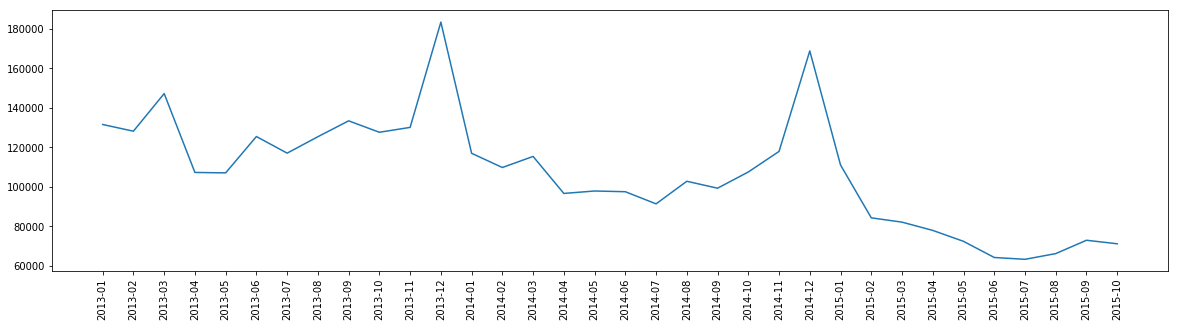

In [7]:
# Calculate the aggregate function on given fields
def aggregate(df, fields, agg_dict, rename_dict):
    return (df.groupby(fields)
              .agg(agg_dict)
              .rename(columns=rename_dict)
              .reset_index())
plot_df = aggregate(train_df, ['date_block_num'], 
                    {'item_cnt_day': 'sum'}, {'item_cnt_day': 'item_cnt_month'})

plt.figure(figsize=(20, 4.8))
plt.plot(range(34), plot_df['item_cnt_month'])
plt.xticks(range(34), train_df['year_month'].unique(), rotation='vertical')
plt.show()

In [9]:
# Shops
print("unique shop_id in shop_df = {0}".format(shops_df['shop_id'].nunique()))
print("the value of shop_id in shop_df is between {0} - {1}".format(min(shops_df['shop_id']), max(shops_df['shop_id'])))
print()
print("5 first rows in shop_df")
shops_df.head()

unique shop_id in shop_df = 60
the value of shop_id in shop_df is between 0 - 59

5 first rows in shop_df


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


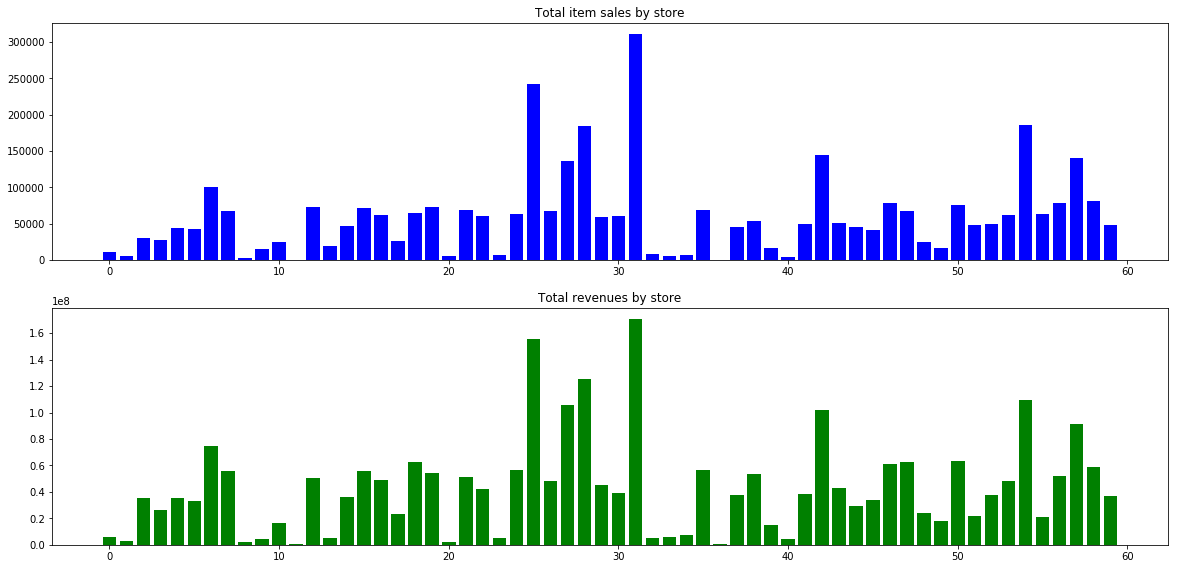

In [11]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(20, 4.8*2))
gs = gridspec.GridSpec(2, 1)

ax = plt.subplot(gs[0])
ax.set_title('Total item sales by store')

plot_df_1 = aggregate(train_df, ['shop_id'], 
                      {'item_cnt_day': 'sum'}, {'item_cnt_day': 'item_cnt'})
plt.bar(plot_df_1['shop_id'], plot_df_1['item_cnt'], color='blue')

ax = plt.subplot(gs[1])
ax.set_title('Total revenues by store')

plot_df_2 = aggregate(train_df, ['shop_id'], 
                      {'item_price': 'sum'}, {'item_price': 'item_price'})
plt.bar(plot_df_2['shop_id'], plot_df_2['item_price'], color='green')

plt.show()

From the graphs, we have seen that the items saled and the revenues are directly proportional and there are variances among the shops, some shops had little sales, while some shops saled a lot.

Now, I will plot the total sales count of each shop in each month

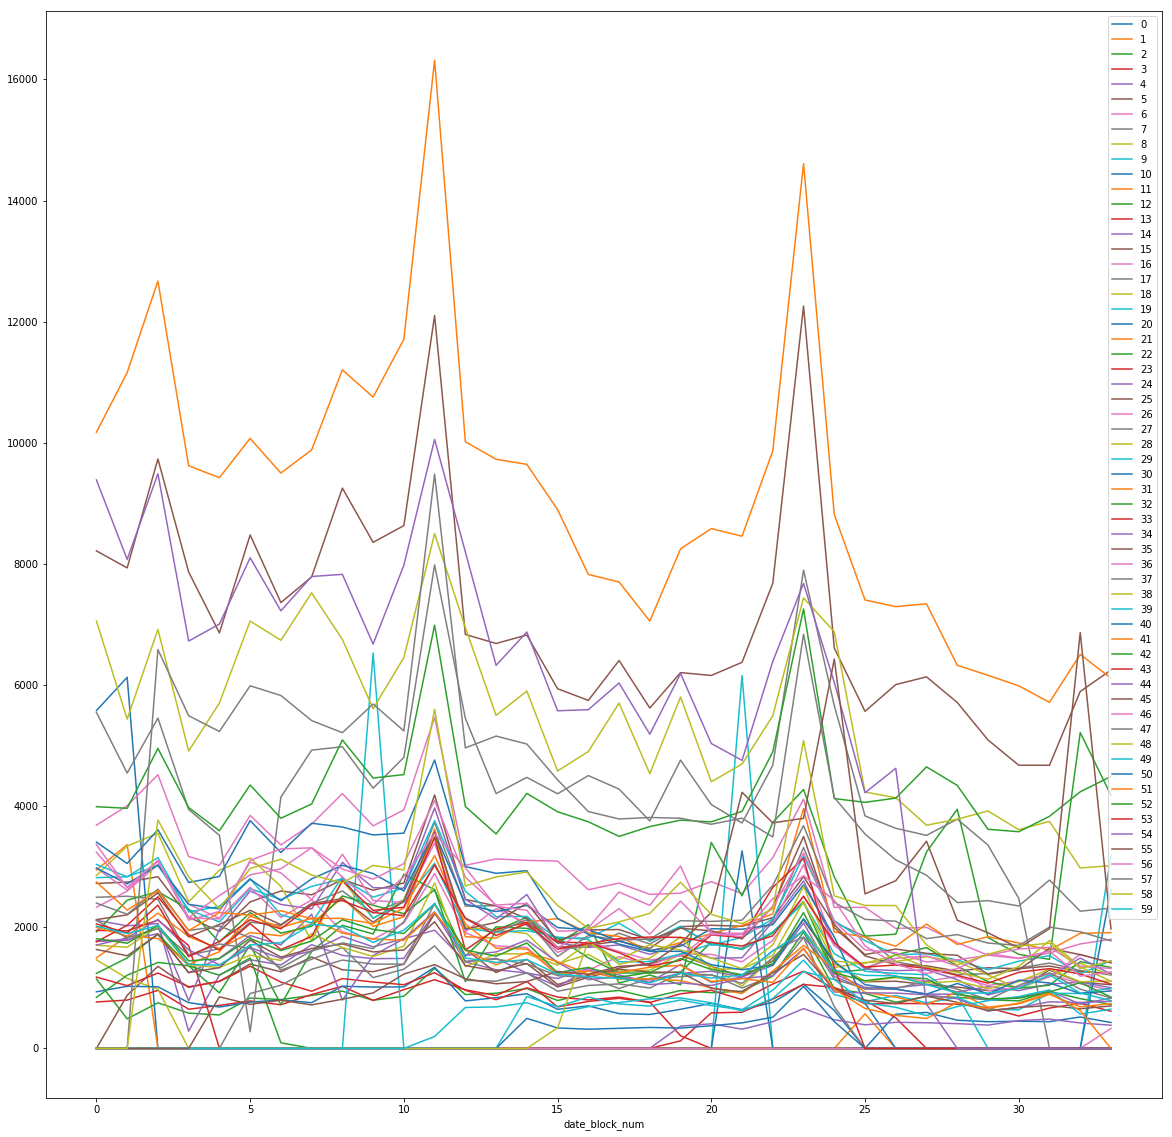

In [12]:
plot_df = aggregate(grid_df, ['shop_id', 'date_block_num'], 
                    {'item_cnt_month': 'sum'}, {'item_cnt_month': 'item_cnt_month'})

fig, ax = plt.subplots(figsize=(20, 20))
for label, df in plot_df.groupby('shop_id'):
    df.plot(x='date_block_num', y='item_cnt_month', ax=ax, label=label)
plt.show()

From the graph, we have seen that some shops, for example shop 9, only sale for some months. And the sales of all shops are highly correlated.

In [14]:
# Items
print("unique item_id in item_df = {0}".format(items_df['item_id'].nunique()))
print("the value of item_id in item_df is between {0} - {1}".format(min(items_df['item_id']), max(items_df['item_id'])))
print()
print("5 first rows in item_df")
items_df.head()

unique item_id in item_df = 22170
the value of item_id in item_df is between 0 - 22169

5 first rows in item_df


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [15]:
uniques = np.unique(train_df[['item_id']])
print("# of items on sale = {0}".format(len(uniques)))

# of items on sale = 21807


In [18]:
print("unique category_id in icats_df = {0}".format(icats_df['item_category_id'].nunique()))
print("the value of category_id in icats_df is between {0} - {1}".format(min(icats_df['item_category_id']), max(icats_df['item_category_id'])))
print()
print("5 first rows in category_df")
icats_df.head()

unique category_id in icats_df = 84
the value of category_id in icats_df is between 0 - 83

5 first rows in category_df


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [20]:
# Bestsellers
agg_item_df_1 = aggregate(train_df, ['item_id'], 
                          {'item_cnt_day': 'sum'}, {'item_cnt_day': 'total_item_cnt'})
agg_item_df_1 = (pd.merge(agg_item_df_1, items_df, on='item_id', how='left')
                   .sort_values(by='total_item_cnt', ascending=False))
print("top 5 bestselling items by count")
agg_item_df_1.head()

top 5 bestselling items by count


,item_id,total_item_cnt,item_name,item_category_id
20602,20949,187642.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
2749,2808,17245.0,"Diablo III [PC, Jewel, русская версия]",30
3654,3732,16642.0,"Grand Theft Auto V [PS3, русские субтитры]",19
17418,17717,15830.0,Прием денежных средств для 1С-Онлайн,79
5717,5822,14515.0,Playstation Store пополнение бумажника: Карта ...,35


In [21]:
agg_item_df_2 = aggregate(train_df, ['item_id'], 
                          {'item_price': 'sum'}, {'item_price': 'total_revenue'})
agg_item_df_2 = (pd.merge(agg_item_df_2, items_df, on='item_id', how='left')
                   .sort_values(by='total_revenue', ascending=False))
print("top 5 bestselling items by revenue")
agg_item_df_2.head()

top 5 bestselling items by revenue


,item_id,total_revenue,item_name,item_category_id
6543,6675,1.132643e+08,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12
13195,13443,2.135946e+07,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,12
3654,3732,1.756505e+07,"Grand Theft Auto V [PS3, русские субтитры]",19
3656,3734,1.589006e+07,"Grand Theft Auto V [Xbox 360, русские субтитры]",23
5718,5823,1.307078e+07,Playstation Store пополнение бумажника: Карта ...,35


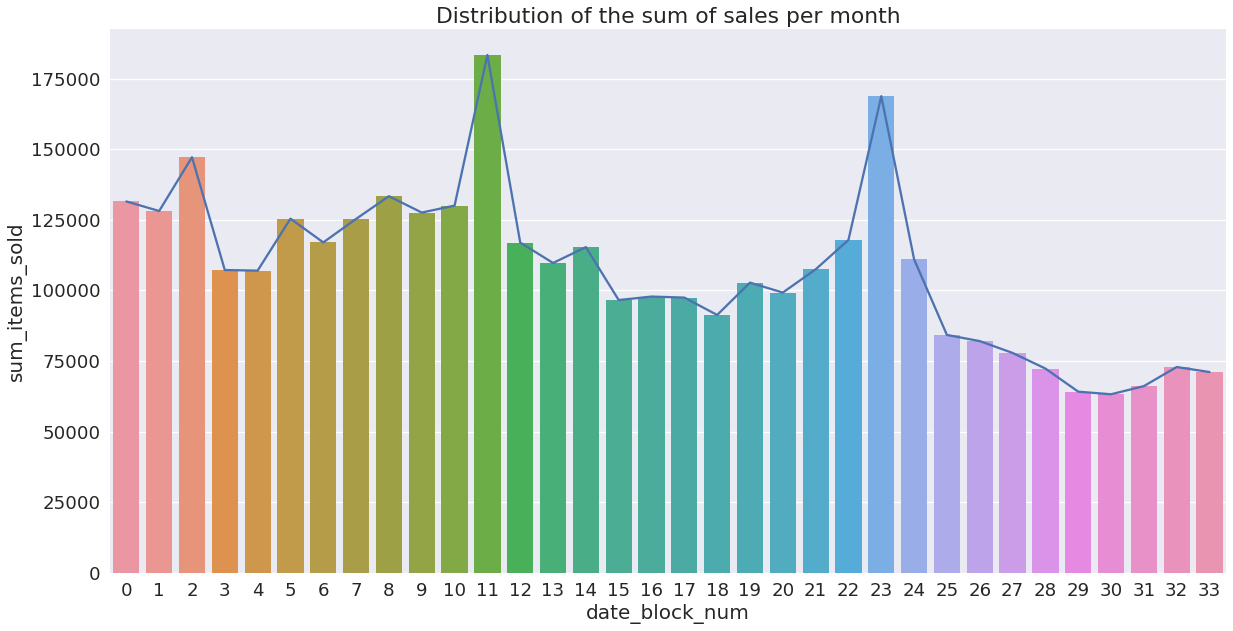

In [26]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("talk", font_scale=1.4)
sales_month = pd.DataFrame(train_df.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
del sales_month

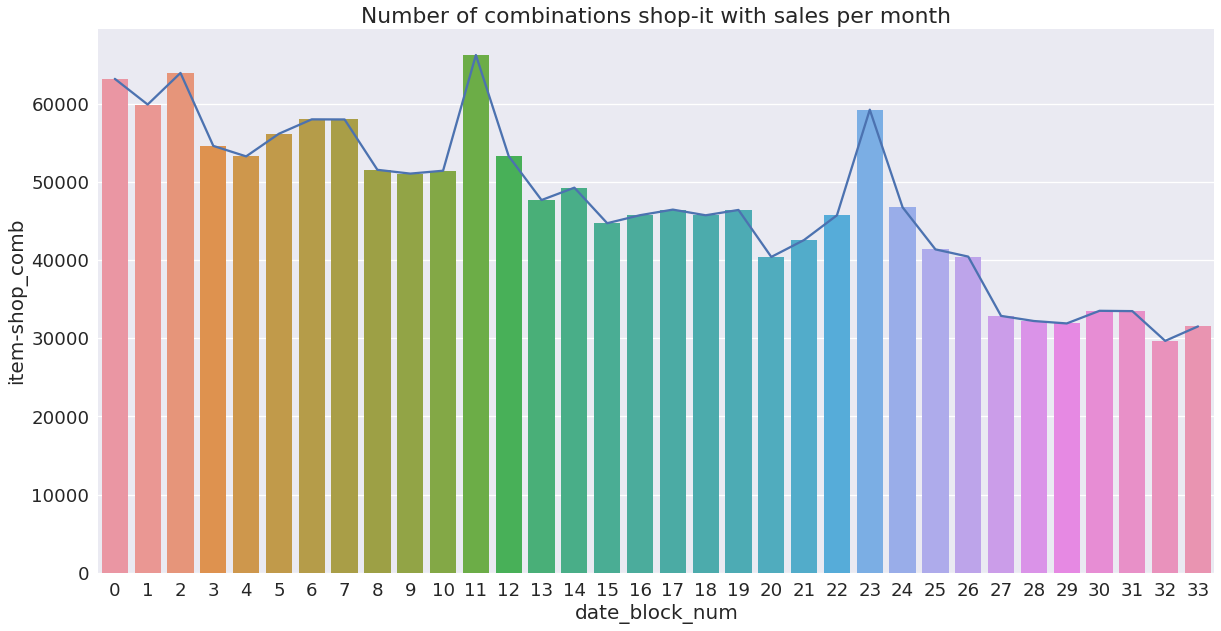

In [27]:
comb_shop_item = pd.DataFrame(train_df[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations shop-it with sales per month')
del comb_shop_item

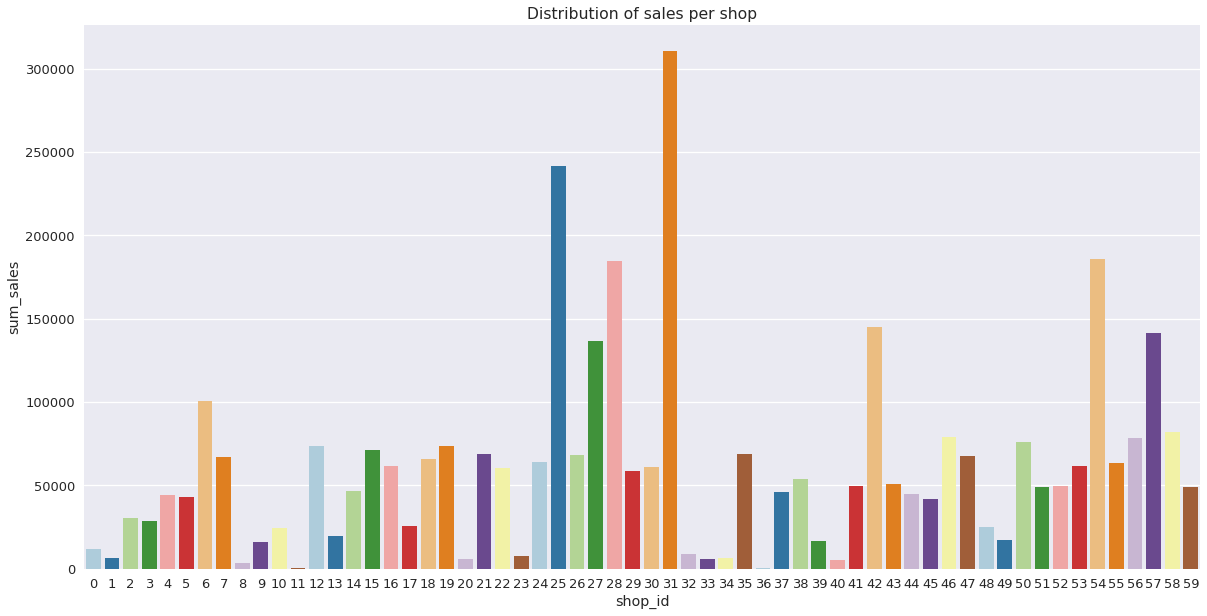

In [28]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(train_df.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

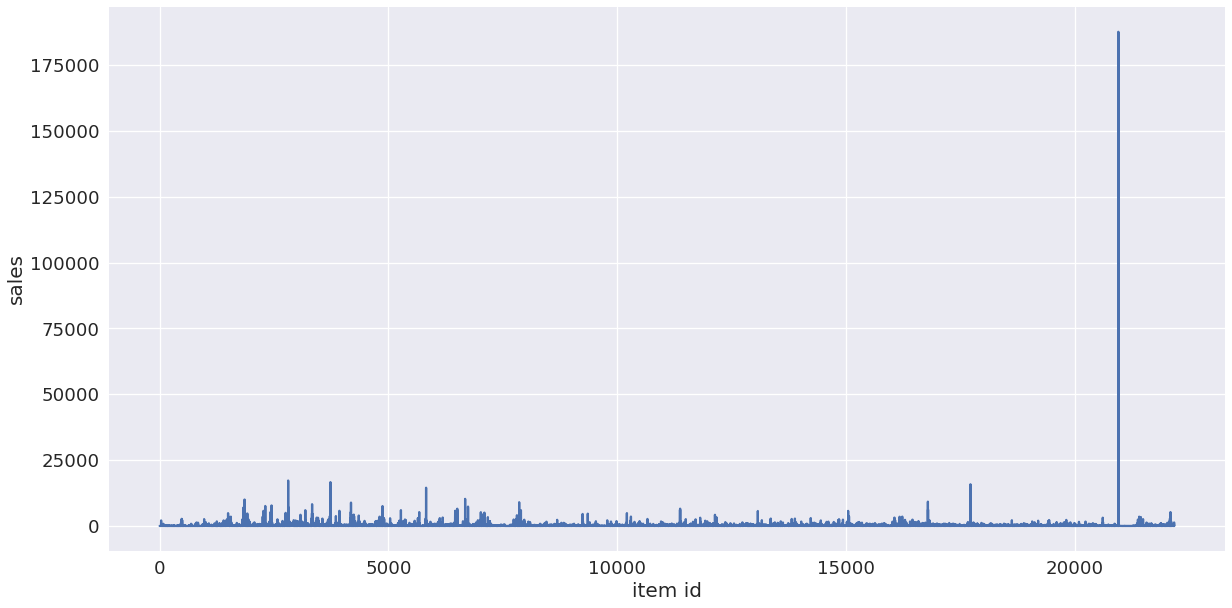

In [29]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(train_df.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

In [30]:
anomaly_item = sales_item_id.item_cnt_day.argmax()
anomaly_item

/home/kostya/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


20949

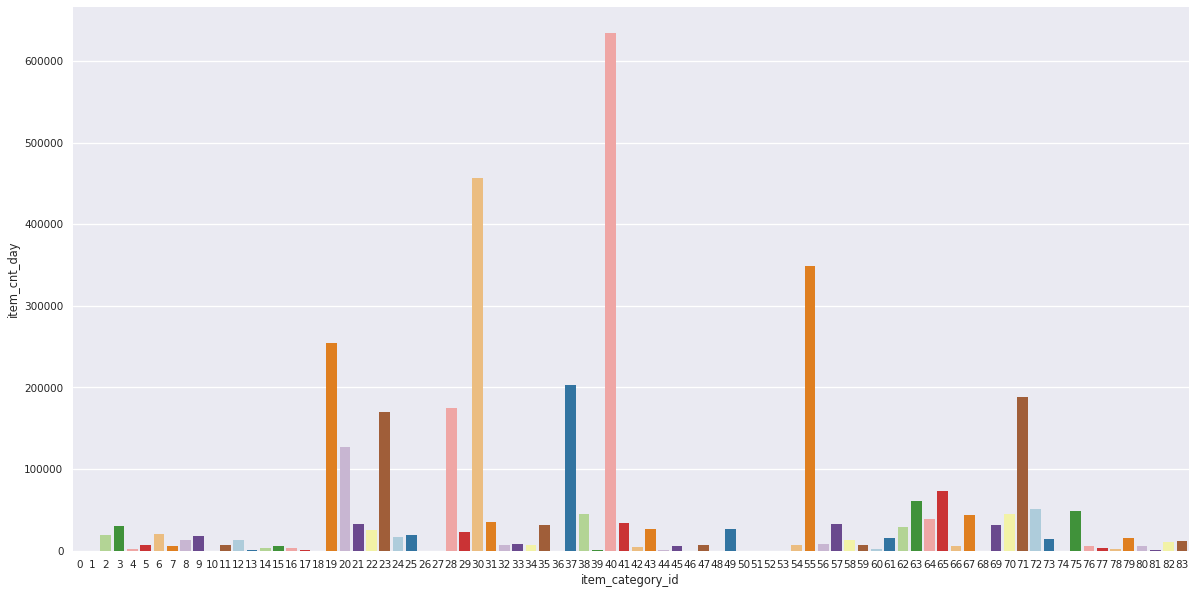

In [32]:
#fig, ax = plt.subplots()
sns.set_context("talk", font_scale=0.8)
sales_item_cat = train_df.merge(items_df, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=sales_item_cat.reset_index(), 
            palette='Paired'
           );
del sales_item_cat